In [1]:
from timeit import default_timer as timer
import numpy as np
import pandas as pd
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras_helper import NNWeightHelper
from snes import SNES
import os
import cv2
import matplotlib.pyplot as plt
from dataSet import dataSet

Using TensorFlow backend.


In [2]:
#randomforest classifier
def train_classifier(model, X, y):
    X_features = model.predict(X)
    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(X_features, y)
    y_pred = clf.predict(X_features)
    return clf, y_pred
#prediction 
def predict_classifier(model, clf, X):
    X_features = model.predict(X)
    return clf.predict(X_features)

# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 31

# use just a small sample of the train set to test
SAMPLE_SIZE = 300
# how many different sets of weights ask() should return for evaluation
POPULATION_SIZE = 20
# how many times we will loop over ask()/tell()
GENERATIONS = 60

In [3]:
#Loading the data from path-
# This part adopted from LYU CHAOFAN_Github(permission was obtained)https://github.com/C-002/CE888_Assignment/blob/master/LoadImages.ipynb
Amazon_path = './Original_images/amazon/images'
dslr_path   = './Original_images/dslr/images'
webcam_path = './Original_images/webcam/images'
paths = [Amazon_path, dslr_path, webcam_path]
files = os.listdir(Amazon_path)
labels = {}
count  = 0
for key in files:
    a = {key : count}
    labels.update(a)
    count += 1
# print (labels)
images_path = []
Amazon = dataSet()
webcam = dataSet()
#loading Amazon data
for dirname in files:
    images_name = os.listdir(Amazon_path + '/' + dirname)
    for name in images_name:
        Image_Path = Amazon_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        Amazon.upData(image_data, labels[dirname], labels)
Amazon.sHape()
#loading webcam data
for dirname in files:
    images_name = os.listdir(webcam_path + '/' + dirname)
    for name in images_name:
        Image_Path = webcam_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        webcam.upData(image_data, labels[dirname], labels)
webcam.sHape()

#label classifier data
x_train = Amazon.data
y_train = Amazon.label
x_test  = webcam.data
y_test  = webcam.label
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)
#data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
#domain classifier data
x_domain=np.concatenate((x_train,x_test), axis =0)
y_domain = np.concatenate((np.zeros(y_train.shape[0]), np.ones(y_test.shape[0])),axis=0)
print("For label classifier")
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("For domain classifier")
print('x_domain shape:', x_domain.shape)
print(y_domain.shape[0], 'domain samples')

For label classifier
x_train shape: (2817, 28, 28, 3)
x_test shape: (795, 28, 28, 3)
2817 train samples
795 test samples
For domain classifier
x_domain shape: (3612, 28, 28, 3)
3612 domain samples


In [4]:
#the neural network model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(28,28,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
nnw = NNWeightHelper(model)
weights = nnw.get_weights()

In [5]:
print("Total number of weights to evolve is:", weights.shape)
all_examples_indices = list(range(x_train.shape[0]))
clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)
print('x_test shape:',y_test.shape)
print('x_pred shape:',y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)
print('Non-trained NN Test accuracy:', test_accuracy)

Total number of weights to evolve is: (941092,)


x_test shape: (795,)
x_pred shape: (795,)
Non-trained NN Test accuracy: 0.052830188679245285


In [6]:
#evolutionary process with SNES
snes = SNES(weights, 1, POPULATION_SIZE)
log = []
for i in range(0, GENERATIONS):
    start = timer()
    asked = snes.ask()

    # to be provided back to snes
    told = []
    # use a small number of training samples for speed purposes
    subsample_indices = np.random.choice(all_examples_indices, size=SAMPLE_SIZE, replace=False)
    # evaluate on another subset
    subsample_indices_valid = np.random.choice(all_examples_indices, size=SAMPLE_SIZE + 1, replace=False)

    # iterate over the population
    for asked_j in asked:
        # set nn weights
        nnw.set_weights(asked_j)
        # train the classifer and get back the predictions on the training data
        clf, _ = train_classifier(model, x_train[subsample_indices], y_train[subsample_indices])
        clf2, _ = train_classifier(model, x_domain[subsample_indices], y_domain[subsample_indices])

        # calculate the predictions on a different set
        y_pred = predict_classifier(model, clf, x_train[subsample_indices_valid])
        score = accuracy_score(y_train[subsample_indices_valid], y_pred)

        y_pred2 = predict_classifier(model, clf, x_domain[subsample_indices_valid])
        score2 = accuracy_score(y_domain[subsample_indices_valid], y_pred)
                    
        # append to array of values that are to be returned
        total=score+score2
        told.append(total)

    t = snes.tell(asked, told)
    log.append(t)
    end = timer()
    print("It took", end - start, "seconds to complete generation", i + 1)
nnw.set_weights(snes.center)

clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)
print(y_test.shape, y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy on target:', test_accuracy)

Step 1.0 : 0.34883720930232553 best: 0.34883720930232553 20


It took 19.612248006744856 seconds to complete generation 1


Step 2.0 : 0.32558139534883723 best: 0.34883720930232553 20


It took 20.297393914326086 seconds to complete generation 2


Step 3.0 : 0.3521594684385382 best: 0.3521594684385382 20


It took 21.882903687279594 seconds to complete generation 3


Step 4.0 : 0.3554817275747508 best: 0.3554817275747508 20


It took 22.378034224290438 seconds to complete generation 4


Step 5.0 : 0.3853820598006644 best: 0.3853820598006644 20


It took 22.028665285113675 seconds to complete generation 5


Step 6.0 : 0.3289036544850498 best: 0.3853820598006644 20


It took 21.49296723236995 seconds to complete generation 6


Step 7.0 : 0.3588039867109634 best: 0.3853820598006644 20


It took 21.92764936058215 seconds to complete generation 7


Step 8.0 : 0.3488372093023256 best: 0.3853820598006644 20


It took 21.587977385973403 seconds to complete generation 8


Step 9.0 : 0.3920265780730897 best: 0.3920265780730897 20


It took 20.588007005792434 seconds to complete generation 9


Step 10.0 : 0.3388704318936877 best: 0.3920265780730897 20


It took 20.76842484975876 seconds to complete generation 10


Step 11.0 : 0.3289036544850498 best: 0.3920265780730897 20


It took 21.04726053698616 seconds to complete generation 11


Step 12.0 : 0.3853820598006644 best: 0.3920265780730897 20


It took 20.869927032986254 seconds to complete generation 12


Step 13.0 : 0.3853820598006644 best: 0.3920265780730897 20


It took 20.524939006092893 seconds to complete generation 13


Step 14.0 : 0.3654485049833887 best: 0.3920265780730897 20


It took 20.480055106968052 seconds to complete generation 14


Step 15.0 : 0.3853820598006645 best: 0.3920265780730897 20


It took 20.503867325778174 seconds to complete generation 15


Step 16.0 : 0.3388704318936877 best: 0.3920265780730897 20


It took 20.724136873183795 seconds to complete generation 16


Step 17.0 : 0.33554817275747506 best: 0.3920265780730897 20


It took 20.437070755047955 seconds to complete generation 17


Step 18.0 : 0.4019933554817276 best: 0.4019933554817276 20


It took 20.46385976567194 seconds to complete generation 18


Step 19.0 : 0.3754152823920266 best: 0.4019933554817276 20


It took 20.456584573927728 seconds to complete generation 19


Step 20.0 : 0.37209302325581395 best: 0.4019933554817276 20


It took 20.491947111697414 seconds to complete generation 20


Step 21.0 : 0.4186046511627907 best: 0.4186046511627907 20


It took 20.45078614173292 seconds to complete generation 21


Step 22.0 : 0.3554817275747508 best: 0.4186046511627907 20


It took 20.522824362583265 seconds to complete generation 22


Step 23.0 : 0.4119601328903655 best: 0.4186046511627907 20


It took 20.438211823314987 seconds to complete generation 23


Step 24.0 : 0.39867109634551495 best: 0.4186046511627907 20


It took 20.502517860927185 seconds to complete generation 24


Step 25.0 : 0.398671096345515 best: 0.4186046511627907 20


It took 20.7183955649258 seconds to complete generation 25


Step 26.0 : 0.34219269102990035 best: 0.4186046511627907 20


It took 20.751420605309136 seconds to complete generation 26


Step 27.0 : 0.3488372093023256 best: 0.4186046511627907 20


It took 20.5719717525659 seconds to complete generation 27


Step 28.0 : 0.42524916943521596 best: 0.42524916943521596 20


It took 20.710153497659803 seconds to complete generation 28


Step 29.0 : 0.38205980066445183 best: 0.42524916943521596 20


It took 20.477515207485112 seconds to complete generation 29


Step 30.0 : 0.39867109634551495 best: 0.42524916943521596 20


It took 20.519707934479584 seconds to complete generation 30


Step 31.0 : 0.4152823920265781 best: 0.42524916943521596 20


It took 20.46559887219007 seconds to complete generation 31


Step 32.0 : 0.3621262458471761 best: 0.42524916943521596 20


It took 21.808086845309504 seconds to complete generation 32


Step 33.0 : 0.43521594684385384 best: 0.43521594684385384 20


It took 21.634197350507293 seconds to complete generation 33


Step 34.0 : 0.34883720930232553 best: 0.43521594684385384 20


It took 20.644133389328886 seconds to complete generation 34


Step 35.0 : 0.4053156146179402 best: 0.43521594684385384 20


It took 20.572801812732905 seconds to complete generation 35


Step 36.0 : 0.3289036544850498 best: 0.43521594684385384 20


It took 20.546177474198203 seconds to complete generation 36


Step 37.0 : 0.3853820598006644 best: 0.43521594684385384 20


It took 21.62616967431245 seconds to complete generation 37


Step 38.0 : 0.37209302325581395 best: 0.43521594684385384 20


It took 20.50270474788067 seconds to complete generation 38


Step 39.0 : 0.42192691029900337 best: 0.43521594684385384 20


It took 20.696483598554096 seconds to complete generation 39


Step 40.0 : 0.38205980066445183 best: 0.43521594684385384 20


It took 20.50559338547123 seconds to complete generation 40


Step 41.0 : 0.3920265780730897 best: 0.43521594684385384 20


It took 20.654210122291033 seconds to complete generation 41


Step 42.0 : 0.3554817275747508 best: 0.43521594684385384 20


It took 20.71644100948572 seconds to complete generation 42


Step 43.0 : 0.34883720930232553 best: 0.43521594684385384 20


It took 20.893237477956973 seconds to complete generation 43


Step 44.0 : 0.415282392026578 best: 0.43521594684385384 20


It took 20.618495672861854 seconds to complete generation 44


Step 45.0 : 0.3754152823920266 best: 0.43521594684385384 20


It took 20.537782723817372 seconds to complete generation 45


Step 46.0 : 0.37873754152823924 best: 0.43521594684385384 20


It took 20.525155160248573 seconds to complete generation 46


Step 47.0 : 0.40199335548172754 best: 0.43521594684385384 20


It took 20.553240743189463 seconds to complete generation 47


Step 48.0 : 0.35215946843853824 best: 0.43521594684385384 20


It took 20.531324545415146 seconds to complete generation 48


Step 49.0 : 0.39534883720930236 best: 0.43521594684385384 20


It took 21.195107158510837 seconds to complete generation 49


Step 50.0 : 0.38870431893687707 best: 0.43521594684385384 20


It took 21.14319666255153 seconds to complete generation 50


Step 51.0 : 0.38870431893687707 best: 0.43521594684385384 20


It took 23.134253592901587 seconds to complete generation 51


Step 52.0 : 0.3853820598006645 best: 0.43521594684385384 20


It took 20.93868909028015 seconds to complete generation 52


Step 53.0 : 0.3122923588039867 best: 0.43521594684385384 20


It took 23.721261635035034 seconds to complete generation 53


Step 54.0 : 0.3222591362126246 best: 0.43521594684385384 20


It took 20.91900037342134 seconds to complete generation 54


Step 55.0 : 0.3588039867109635 best: 0.43521594684385384 20


It took 20.62333357663897 seconds to complete generation 55


Step 56.0 : 0.3853820598006644 best: 0.43521594684385384 20


It took 21.31750154005431 seconds to complete generation 56


Step 57.0 : 0.31229235880398676 best: 0.43521594684385384 20


It took 20.61544130533116 seconds to complete generation 57


Step 58.0 : 0.3588039867109635 best: 0.43521594684385384 20


It took 20.65800004866105 seconds to complete generation 58


Step 59.0 : 0.39534883720930236 best: 0.43521594684385384 20


It took 20.58684478051191 seconds to complete generation 59


Step 60.0 : 0.3089700996677741 best: 0.43521594684385384 20


It took 20.66719947079241 seconds to complete generation 60


(795,) (795,)
Test accuracy on target: 0.07421383647798742


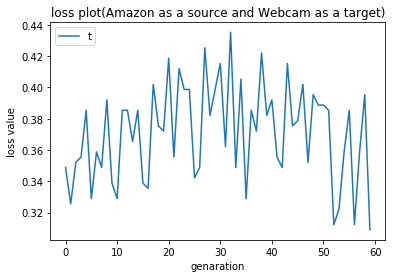

In [7]:
plt.plot(log)
plt.title('loss plot(Amazon as a source and Webcam as a target)')
plt.xlabel('genaration')
plt.ylabel('loss value')
plt.legend('test', loc='upper left')
plt.savefig('Plot_amazon_webcam.png')
plt.show()